# RAG Evaluation
- Original nb from https://huggingface.co/learn/cookbook/en/rag_evaluation#evaluating-rag-performance.   Going fully open source, local, optimized for speed with exl2

- RAG systems are complex: here a RAG diagram, where we noted in blue all possibilities for system enhancement:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">

Implementing any of these improvements can bring a huge performance boost; but changing anything is useless if you cannot monitor the impact of your changes on the system's performance!
So let's see how to evaluate our RAG system.

### Evaluating RAG performance

Since there are so many moving parts to tune with a big impact on performance, benchmarking the RAG system is crucial.

For our evaluation pipeline, we will need:
1. An evaluation dataset with question - answer couples (QA couples)
2. An evaluator to compute the accuracy of our system on the above evaluation dataset.

➡️ It turns out, we can use LLMs to help us all along the way!
1. The evaluation dataset will be synthetically generated by an LLM 🤖, and questions will be filtered out by other LLMs 🤖
2. An [LLM-as-a-judge](https://huggingface.co/papers/2306.05685) agent 🤖 will then perform the evaluation on this synthetic dataset.

__Let's dig into it and start building our evaluation pipeline!__ First, we install the required model dependancies.

In [8]:
from tqdm.auto import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import json
import datasets
import os
import re
pd.set_option("display.max_colwidth", None)

In [2]:
from huggingface_hub import notebook_login

notebook_login()

### Load your knowledge base

# 1. Build a synthetic dataset for evaluation

### 1.1. Prepare source documents

- Drop REFERENCES onward, respecting previous discoveries that these just introduce noise to retrieval.  Must process new docs the same way!

In [10]:
import os
import PyPDF2
from PyPDF2 import PdfReader
from pathlib import Path
PDFS_PATH = Path('/home/mainuser/Desktop/LLMs/RagOverArXiv/clusterofstars')
PDFS = list(PDFS_PATH.glob('*.pdf'))
PDFS[0], len(PDFS)

reader = PdfReader(os.path.expanduser(PDFS[0]))
pages = reader.pages
documents = []
for page in pages:
  documents.append(page.extract_text())


def load_pdf_to_string(pdf_path):
    # Open the PDF file in binary mode
    with open(pdf_path, 'rb') as file:
        # Create a PDF file reader object
        pdf_reader = PyPDF2.PdfReader(file)

        # Initialize an empty string to hold the text
        text = ''

        # Loop through each page and extract the text
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            page_text = page.extract_text()
            references_index= page_text.upper().find('\nREFERENCES\n')
            if references_index != -1:
              page_text = page_text[:references_index]
              text += page_text
              return text
            text += page_text
    return text

# Use the function to load a PDF into a string
text = load_pdf_to_string(os.path.expanduser(PDFS[0]))
def get_title(pdf_path): return os.path.expanduser(pdf_path).split('/')[-1]

all_docs_and_titles = [(load_pdf_to_string(os.path.expanduser(pdf_path)),get_title(pdf_path)) for pdf_path in PDFS]

all_docs = [doc[0] for doc in all_docs_and_titles]
all_titles = [doc[1] for doc in all_docs_and_titles]

from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter, TokenTextSplitter, RecursiveCharacterTextSplitter
from langchain.docstore.document import Document 

# CHUNK_SIZE = 1000 #try 2000 next
# CHUNK_OVERLAP = 30 #try 200 next
CHUNK_SIZE = 2000 #try 2000 next
CHUNK_OVERLAP = 200 #try 200 next

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap = CHUNK_OVERLAP,
    length_function=len,
)

docs_processed  = [text_splitter.split_documents([Document(page_content=doc, metadata={'source':all_titles[idx]})]) 
         for idx,doc in enumerate(all_docs)]



In [11]:
docs_processed = [txt for doc in docs_processed for txt in doc]

In [12]:
len(docs_processed)

700

In [13]:
docs_processed[0]

Document(page_content='CHAIN -OF-VERIFICATION REDUCES HALLUCINATION\nINLARGE LANGUAGE MODELS\nShehzaad Dhuliawala\nMeta AI & ETH Z ¨urichMojtaba Komeili\nMeta AIJing Xu\nMeta AIRoberta Raileanu\nMeta AI\nXian Li\nMeta AIAsli Celikyilmaz\nMeta AIJason Weston\nMeta AI\nABSTRACT\nGeneration of plausible yet incorrect factual information, termed hallucination,\nis an unsolved issue in large language models. We study the ability of language\nmodels to deliberate on the responses they give in order to correct their mistakes.\nWe develop the Chain-of-Verification (C OVE) method whereby the model first (i)\ndrafts an initial response; then (ii) plans verification questions to fact-check its\ndraft; (iii) answers those questions independently so the answers are not biased\nby other responses; and (iv) generates its final verified response. In experiments,\nwe show COVEdecreases hallucinations across a variety of tasks, from list-based\nquestions from Wikidata, closed book MultiSpanQA and longfo

- Make embeddings and save to vector store
- Currently taking from Part3_Metadata+ArXivExplore_single_source nb, should tune

In [54]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)


from langchain.schema.document import Document

for index, pdf in enumerate(docs_processed):
   content = docs_processed[index]
   if index == 0:
       vector_store = FAISS.from_documents([content], embedder)
   else:
      vector_store_i = FAISS.from_documents([content], embedder)
      vector_store.merge_from(vector_store_i)

vector_store


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

#### TODO: Once have the pipeline working and have a baseline, look into https://huggingface.co/spaces/mteb/leaderboard.  SFR-Embedding-Mistral or something along those lines may work much better.

In [57]:
vector_store.save_local('../rag_index_dir')

### 1.2. Setup agents for question generation

- HF used [Mixtral](https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1) for QA couple generation because it it has excellent performance in leaderboards such as [Chatbot Arena](https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard).  Used Mixtral-8x7b-4bit exl2, and it did not appear significantly better than Mistral, so using Mistral for speed but may come back to this.

#### TODO: Tried Mixtral4Bit, visually perhaps a bit better, but overfits on 'deep question'. Perhaps return to this after looking at embedding model

In [6]:
from exllamav2 import *
from exllamav2.generator import *
import sys, torch


generator_config = ExLlamaV2Config()
generator_config.model_dir = "/home/mainuser/Desktop/LLMs/MiStralInference"
#generator_config.model_dir = '/home/mainuser/Desktop/LLMs/Mixtral4bit'
generator_config.prepare()

generator_model = ExLlamaV2(generator_config)
cache = ExLlamaV2Cache(generator_model, lazy = True)

print("Loading model...")
generator_model.load_autosplit(cache)

generator_tokenizer = ExLlamaV2Tokenizer(generator_config)
generator_llm = ExLlamaV2StreamingGenerator(generator_model, cache, generator_tokenizer)
generator_llm.set_stop_conditions([generator_tokenizer.eos_token_id])
generator_settings = ExLlamaV2Sampler.Settings()
generator_settings.temperature = 0.85
generator_settings.top_k = 50
generator_settings.top_p = 0.8
generator_settings.token_repetition_penalty = 1.01
#generator_settings.disallow_tokens(generator_tokenizer, [generator_tokenizer.eos_token_id])
# see if commenting out the above solved the endless generation issue (did not have with stream generator)

Loading model...


In [13]:
#Working except eos
from transformers import Pipeline
from ragatouille import RAGPretrainedModel
from typing import Optional, List, Tuple
from langchain.docstore.document import Document
import time

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
from langchain.docstore.document import Document as LangchainDocument
def call_llm(
    question: str,
    generator: ExLlamaV2StreamingGenerator,
    tokenizer: ExLlamaV2Tokenizer,
    settings:ExLlamaV2Sampler.Settings,
    max_new_tokens = 512
) -> Tuple[str, List[LangchainDocument]]:

    max_new_tokens = max_new_tokens

    generator.warmup()
    output = generator.generate_simple(f"<s>[INST] {question} [/INST]", settings, max_new_tokens, seed = 1234)
    return output


call_llm(question="How can I get my cat to like me?", generator=generator_llm,tokenizer=generator_tokenizer,settings=generator_settings,max_new_tokens=1024)

'<s>[INST] How can I get my cat to like me? [/INST] 1. Spend time with your cat: Cats enjoy spending time with their owners, so take some time out of your day to play with them or simply sit with them.\n\n2. Provide food and shelter: Ensure that your cat has access to good food and a comfortable place to sleep.\n\n3. Show affection: Cats love physical touch, so try petting them or giving them a gentle scratch behind their ears.\n\n4. Play with toys: Cats enjoy playing with toys, so try introducing them to some new ones.\n\n5. Be patient: Cats can be slow to warm up to new people, so be patient and give them time to get used to you.\n\n6. Use positive reinforcement: Reward your cat with treats or praise when they interact with you positively.\n\n7. Avoid loud noises: Cats can be easily startled by loud noises, so try to keep your voice and movements calm around them.\n\n8. Be consistent: Consistency is key when it comes to building a relationship with your cat. Try to spend the same amo

In [14]:
QA_generation_prompt = """
Your task is to write a deep factual or conceptual question and an answer given a context.
Your deep question should be unambigiously answerable from the context.
Your deep question should be formulated in the same style as questions people reading advanced LLM papers would ask.
This means that your question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Deep question: (your deep question)
Answer: (your answer to the deep question)

Now here is the context.

Context: {context}\n
Output:::"""

Now let's generate our QA couples.
For this example, we generate only 10 QA couples and will load the rest from the Hub.

But for your specific knowledge base, given that you want to get at least ~100 test samples, and accounting for the fact that we will filter out around half of these with our critique agents later on, you should generate much more, in the >200 samples.

In [15]:
import random
from tqdm import tqdm
N_GENERATIONS = 300  # We intentionally generate only 10 QA couples here for cost and time considerations

print(f"Generating {N_GENERATIONS} QA couples...")

outputs = []
for sampled_context in tqdm(random.sample(docs_processed, N_GENERATIONS)):
    # Generate QA couple
    # output_QA_couple = call_llm(
    #     llm_client, QA_generation_prompt.format(context=sampled_context.page_content)
    # )
    output_QA_couple = call_llm(question=QA_generation_prompt.format(context=sampled_context.page_content), generator=generator_llm,tokenizer=generator_tokenizer,settings=generator_settings,
                                max_new_tokens=1024)
    try:
        question = output_QA_couple.split("Deep question: ")[-1].split("Answer: ")[0]
        answer = output_QA_couple.split("Answer: ")[-1]
        #assert len(answer) < 300, "Answer is too long"
        outputs.append(
            {
                "context": sampled_context.page_content,
                "question": question,
                "answer": answer,
                "source_doc": sampled_context.metadata["source"],
            }
        )
    except:
        continue

Generating 300 QA couples...


100%|██████████| 300/300 [07:15<00:00,  1.45s/it]


In [3]:
outputs

In [20]:
import pandas as pd
pd.set_option('display.max_colwidth',800)
display(pd.DataFrame(outputs).head(10))

### 1.3. Setup critique agents

The questions generated by the previous agent can have many flaws: we should do a quality check before validating these questions.

We thus build critique agents that will rate each question on several criteria, given in [this paper](https://huggingface.co/papers/2312.10003):
- **Groundedness:** can the question be answered from the given context?
- **Relevance:** is the question relevant to users? For instance, `"What is the date when transformers 4.29.1 was released?"` is not relevant for ML practicioners.

One last failure case we've noticed is when a function is tailored for the particular setting where the question was generated, but undecipherable by itself, like `"What is the name of the function used in this guide?"`.
We also build a critique agent for this criteria:
- **Stand-alone**: is the question understandable free of any context, for someone with domain knowledge/Internet access? The opposite of this would be `What is the function used in this article?` for a question generated from a specific blog article.

We systematically score functions with all these agents, and whenever the score is too low for any one of the agents, we eliminate the question from our eval dataset.

💡 ___When asking the agents to output a score, we first ask them to produce its rationale. This will help us verify scores, but most importantly, asking it to first output rationale gives the model more tokens to think and elaborate an answer before summarizing it into a single score token.___

We now build and run these critique agents.

In [21]:

## Semi-working backup
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: !!!(your rating, as a number between 1 and 5)!!!

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.  'Total rating:' should be encolsed in !!! and !!! as in '!!!4.5!!!'.


Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: !!!(your rating, as a number between 1 and 5)!!!

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.  'Total rating:' should be encolsed in !!! and !!! as in '!!!4.5!!!'.


Now here is the question.

Question: {question}\n
Answer::: """

question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independent this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independent from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: !!!(your rating, as a number between 1 and 5)!!!

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.  'Total rating:' should be encolsed in !!! and !!! as in '!!!4.5!!!'.


Now here is the question.

Question: {question}\n
Answer::: """

In [23]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independant this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independant from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

In [50]:
print("Generating critique for each QA couple...")
for output in tqdm(outputs):
    evaluations = {
        "groundedness": call_llm(question=question_groundedness_critique_prompt.format(context=output["context"], question=output["question"]), 
                                generator=generator_llm,
                                tokenizer=generator_tokenizer,settings=generator_settings,
                                max_new_tokens=1024),
        "relevance": call_llm(question=question_relevance_critique_prompt.format(question=output["question"]), 
                                generator=generator_llm,
                                tokenizer=generator_tokenizer,settings=generator_settings,
                                max_new_tokens=1024),
                    
        "standalone": call_llm(question=question_standalone_critique_prompt.format(question=output["question"]),
                                generator=generator_llm,
                                tokenizer=generator_tokenizer,settings=generator_settings,
                                max_new_tokens=1024)
    }
    try:
        for criterion, evaluation in evaluations.items():
            score, eval = (
                # int(evaluation.split("Total rating: ")[-1].strip()),
                (evaluation.split("Total rating: ")[-1].strip()),
                evaluation.split("Total rating: ")[-2].split("Evaluation: ")[1],
            )
            output.update(
                {
                    f"{criterion}_score": score,
                    f"{criterion}_eval": eval,
                }
            )
    except Exception as e:
        #print("\033[91m" + f"EVALUATION:" + "\033[0m")
        #print(evaluations)
        #print("\033[91m" + f"EXCEPTION: {e}" + "\033[0m")
        continue

In [4]:
evaluations

Now let us filter out bad questions based on our critique agent scores:

In [26]:
outputs[0].keys()

dict_keys(['context', 'question', 'answer', 'source_doc', 'groundedness_score', 'groundedness_eval'])

In [5]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

generated_questions = pd.DataFrame.from_dict(outputs)

print("Evaluation dataset before filtering:")
display(
    generated_questions[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)

In [39]:
generated_questions['groundedness_score']=generated_questions['groundedness_score'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)
generated_questions['relevance_score']=generated_questions['relevance_score'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)
generated_questions['standalone_score']=generated_questions['groundedness_score'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

In [34]:
generated_questions.to_csv("./data/generated_questions_raw.csv", index=False)

In [1]:
display(
    generated_questions[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)

In [41]:
for col in ["groundedness_score", "relevance_score", "standalone_score"]:
    generated_questions[col] = generated_questions[col].fillna(generated_questions[["groundedness_score", "relevance_score", "standalone_score"]].min(axis=1))

In [2]:

generated_questions = generated_questions.loc[
    (generated_questions["groundedness_score"] >= 3.0)
    & (generated_questions["relevance_score"] >= 3.0)
    & (generated_questions["standalone_score"] >= 3.0)
]
print("============================================")
print("Final evaluation dataset:")
display(
    generated_questions[
        [
            "question",
            "answer",
            "groundedness_score",
            "relevance_score",
            "standalone_score",
        ]
    ]
)

# eval_dataset = datasets.Dataset.from_pandas(
#     generated_questions, split="train", preserve_index=False
# )

In [43]:
generated_questions.to_csv("./data/generated_questions_filtered.csv", index=False)

In [51]:
#generated_questions.head()

- Go through the 181 rows remaining post dropping missing vals and missing value imputation visually, keep the better 120ish questions
    - Dropped questions that were off-target for learning about LLMs, relied on the reference section, or mentioned the context.

In [9]:
eval_dataset = pd.read_csv("../data/generated_questions_filtered_w_human.csv")

In [10]:
eval_dataset.shape

(121, 10)

In [3]:
#eval_dataset.head()

# 2. Build our RAG System

### 2.1. Preprocessing documents to build our vector database

- In this part, __we split the documents from our knowledge base into smaller chunks__: these will be the snippets that are picked by the Retriever, to then be ingested by the Reader LLM as supporting elements for its answer.
- The goal is to build semantically relevant snippets: not too small to be sufficient for supporting an answer, and not too large too avoid diluting individual ideas.

Many options exist for text splitting:
- split every `n` words / characters, but this has the risk of cutting in half paragraphs or even sentences
- split after `n` words / character, but only on sentence boundaries
- **recursive split** tries to preserve even more of the document structure, by processing it tree-like way, splitting first on the largest units (chapters) then recursively splitting on smaller units (paragraphs, sentences).

To learn more about chunking, I recommend you read [this great notebook](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/5_Levels_Of_Text_Splitting.ipynb) by Greg Kamradt.

[This space](https://huggingface.co/spaces/m-ric/chunk_visualizer) lets you visualize how different splitting options affect the chunks you get.

> In the following, we use Langchain's `RecursiveCharacterTextSplitter`.

💡 _To measure chunk length in our Text Splitter, our length function will not be the count of characters, but the count of tokens in the tokenized text: indeed, for subsequent embedder that processes token, measuring length in tokens is more relevant and empirically performs better._

### 2.2. Retriever - embeddings 🗂️
The __retriever acts like an internal search engine__: given the user query, it returns the most relevant documents from your knowledge base.

> For the knowledge base, we use Langchain vector databases since __it offers a convenient [FAISS](https://github.com/facebookresearch/faiss) index and allows us to keep document metadata throughout the processing__.

🛠️ __Options included:__

- Tune the chunking method:
    - Size of the chunks
    - Method: split on different separators, use [semantic chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)...
- Change the embedding model

### 2.3. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved documents to formulate its answer.__

🛠️ Here we tried the following options to improve results:
- Switch reranking on/off
- Change the reader model

TODO: Already have Mixtral, use it

In [3]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore
store = LocalFileStore("./cache/")

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)
embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

vector_store = FAISS.load_local('../rag_index_dir', embedder,allow_dangerous_deserialization=True)

In [4]:
RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""

In [5]:
from exllamav2 import *
from exllamav2.generator import *
import sys, torch


reader_config = ExLlamaV2Config()
reader_config.model_dir = "/home/mainuser/Desktop/LLMs/ZephyrInference"
#reader_config.model_dir = '/home/mainuser/Desktop/LLMs/Mixtral4bit'
reader_config.prepare()

reader_model = ExLlamaV2(reader_config)
cache = ExLlamaV2Cache(reader_model, lazy = True)

print("Loading model...")
reader_model.load_autosplit(cache)

reader_tokenizer = ExLlamaV2Tokenizer(reader_config)
reader_llm = ExLlamaV2StreamingGenerator(reader_model, cache, reader_tokenizer)
#reader_llm.set_stop_conditions([reader_tokenizer.eos_token_id])
reader_settings = ExLlamaV2Sampler.Settings()
reader_settings.temperature = 0.85
reader_settings.top_k = 30
reader_settings.top_p = 0.8
reader_settings.token_repetition_penalty = 1.03

Loading model...


In [6]:
import os


#os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'xxx' # added to .bashrc, should be good on next restart

In [15]:
from ragatouille import RAGPretrainedModel
from typing import Optional, List, Tuple
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
from langchain.docstore.document import Document as LangchainDocument
def answer_with_rag(
    question: str,
    generator: ExLlamaV2StreamingGenerator,
   # tokenizer: ExLlamaV2Tokenizer,
    settings:ExLlamaV2Sampler.Settings,
    max_new_tokens = 512,
    knowledge_index: FAISS = vector_store,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 10, #30,
    #num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    embedding_vector = core_embeddings_model.embed_query(question)
    relevant_docs = knowledge_index.similarity_search_by_vector(embedding_vector, k = num_retrieved_docs)#num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    # if reranker:
    #     print("=> Reranking documents...")
    #     relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
    #     #print(f"Type is : {type(relevant_docs[0])}")
    #     print(dir(relevant_docs[0]))
    #     relevant_docs = [doc['page_content'] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_retrieved_docs]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

   
    generator.warmup()
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    answer = generator.generate_simple(final_prompt, 
    settings, max_new_tokens, seed = 1234)
    # print(answer)
    return answer,relevant_docs


answer, relevant_docs = answer_with_rag(question="What is the difference between RAG and self-RAG?", generator=reader_llm,settings=reader_settings,max_new_tokens=512)

=> Retrieving documents...


In [16]:
answer

'\n<|system|>\nUsing the information contained in the context,\ngive a comprehensive answer to the question.\nRespond only to the question asked, response should be concise and relevant to the question.\nProvide the number of the source document when relevant.\nIf the answer cannot be deduced from the context, do not give an answer.</s>\n<|user|>\nContext:\n\nExtracted documents:\nDocument 0:::\nRetrieval Threshold0.60.81.0AccuracyPopQA0.00.51.0\nFrequency\n0.250.500.751.00\nFrequency\n (c) Retrieval\nFigure 3: Analysis on SELF-RAG:(a)Ablation studies for key components of SELF-RAGtraining\nand inference based on our 7B model. (b) Effects of soft weights on ASQA citation precision and\nMauve (fluency). (c) Retrieval frequency andnormalized accuracy on PubHealth and PopQA.\nprecisely grounded yet shorter outputs. Llama2-FT 7B, which is the baseline LM trained on the same\ninstruction-output pairs as SELF-RAGwithout retrieval or self-reflection and is retrieval-augmented\nat test time on

- OK, Zephyr seems to work well, under 4s/question with exl2.  Will try to setup reranker, then onto generating questions and relevant docs.

In [7]:
from ragatouille import RAGPretrainedModel
from typing import Optional, List, Tuple
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
from langchain.docstore.document import Document as LangchainDocument
def answer_with_rag(
    question: str,
    generator: ExLlamaV2StreamingGenerator,
   # tokenizer: ExLlamaV2Tokenizer,
    settings:ExLlamaV2Sampler.Settings,
    max_new_tokens = 512,
    knowledge_index: FAISS = vector_store,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 10, #30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    embedding_vector = core_embeddings_model.embed_query(question)
    relevant_docs = knowledge_index.similarity_search_by_vector(embedding_vector, k = num_retrieved_docs)#num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text


    if reranker:
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]


    relevant_docs = relevant_docs[:num_retrieved_docs]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

   
    generator.warmup()
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    answer = generator.generate_simple(final_prompt, 
    settings, max_new_tokens, seed = 1234)
    return answer,relevant_docs


answer, relevant_docs = answer_with_rag(question="What is the difference between RAG and self-RAG?", generator=reader_llm,settings=reader_settings,max_new_tokens=512,reranker = RERANKER)

=> Retrieving documents...


100%|██████████| 1/1 [00:00<00:00, 23.12it/s]


In [38]:
type(relevant_docs)

list

# 3. Benchmarking the RAG system

The RAG system and the evaluation datasets are now ready. The last step is to judge the RAG system's output on this evlauation dataset.

To this end, __we setup a judge agent__. ⚖️🤖

Out of [the different RAG evaluation metrics](https://docs.ragas.io/en/latest/concepts/metrics/index.html), we choose to focus only on faithfulness since it the best end-to-end metric of our system's performance.

> We use GPT4 as a judge for its empirically good performance, but you could try with other models such as [kaist-ai/prometheus-13b-v1.0](https://huggingface.co/kaist-ai/prometheus-13b-v1.0) or [BAAI/JudgeLM-33B-v1.0](https://huggingface.co/BAAI/JudgeLM-33B-v1.0).

💡 _In the evaluation prompt, we give a detailed description each metric on the scale 1-5, as is done in [Prometheus's prompt template](https://huggingface.co/kaist-ai/prometheus-13b-v1.0): this helps the model ground its metric precisely. If instead you give the judge LLM a vague scale to work with, the outputs will not be consistent enough between different examples._

💡 _Again, prompting the LLM to output rationale before giving its final score gives it more tokens to help it formalize and elaborate a judgement._

In [ ]:
'kaist-ai/prometheus-13b-v1.0'

In [7]:
from langchain_core.vectorstores import VectorStore
import pandas as pd

In [12]:
eval_dataset = pd.read_csv("../data/generated_questions_filtered_w_human.csv")

In [11]:
eval_dataset.head(1)

,context,question,answer,source_doc,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,"Skeleton-of-Thought: Large Language Models Can Do Parallel Decoding\nSKELETON -OF-THOUGHT : L ARGE LANGUAGE MOD-\nELSCANDOPARALLEL DECODING\nXuefei Ning1∗\nfoxdoraame@gmail.comZinan Lin2∗\nlinzinan1995@gmail.com\nZixuan Zhou1∗\nzhouzx21@mails.tsinghua.edu.cnZifu Wang3\nzifu.wang@kuleuven.be\nHuazhong Yang1\nyanghz@tsinghua.edu.cnYu Wang1\nyu-wang@tsinghua.edu.cn\n1Department of Electronic Engineering, Tsinghua University, Beijing, China\n2Microsoft Research, Redmond, Washington, USA\n3ESAT-PSI, KU Leuven, Leuven, Belgium\nWebsite: https://sites.google.com/view/sot-llm\nABSTRACT\nThis work aims at decreasing the end-to-end generation latency of large language\nmodels (LLMs). One of the major causes of the high generation latency is the\nsequential decoding approach adopted by almost all state-of-the-art LLMs. In\nthis work, motivated by the thinking and writing process of humans, we propose\nSkeleton-of-Thought (SoT) , which first guides LLMs to generate the skeleton of\nthe answer, and then conducts parallel API calls or batched decoding to com-\nplete the contents of each skeleton point in parallel . Not only does SoT provide\nconsiderable speed-ups across 12 LLMs, but it can also potentially improve the\nanswer quality on several question categories. SoT is an initial attempt at data-\ncentric optimization for inference efficiency, and further underscores the potential\nof pushing LLMs to think more like a human for answer quality.\n1 I NTRODUCTION\nLarge language models (LLMs) (Brown et al., 2020; Touvron et al., 2023a; Du et al., 2022; OpenAI,\n2023; Zheng et al., 2023) have shown exceptional performance in natural language processing and\nchatbot systems. However, the inference process of the state-of-the-art LLMs is slow, hindering their\ninteractive use. For example, it takes 22 seconds for Claude (Anthropic, 2023) (accessed through\nSlack API) and 43 seconds for Vicuna-33B V1.3 (a 33B LLaMA-based model, running locally on\none NVIDIA A100 GPU) to answer the question in Fig. 1.",Can a large language model with parallel decoding be designed to think more like a human for answer quality?\n\n,"Yes, the proposed Skeleton-of-Thought (SoT) method in the context is an attempt to optimize the inference efficiency of large language models (LLMs) for data-centric optimization, which can potentially improve the answer quality on several question categories. This is achieved by guiding the LLMs to generate the skeleton of the answer first and then conducting parallel API calls or batched decoding to complete the contents of each skeleton point in parallel. The method is an initial attempt at data-centric optimization for inference efficiency and underscores the potential of pushing LLMs to think more like a human for answer quality.",Skeleton-of-Thought_ Large Language Models Can Do Parallel Decoding.pdf,3.0,"While the context provides some relevant information about large language models and parallel decoding, it does not directly address the question of whether a large language model with parallel decoding can be designed to think more like a human for answer quality. \n\n",3.0,NaN,3.0,NaN


In [51]:
from collections import namedtuple
def run_rag_tests(
    dataset: pd.DataFrame,
    llm: ExLlamaV2StreamingGenerator,
    knowledge_index: VectorStore,
    #output_file: str,
    reranker: Optional[RAGPretrainedModel] = None,
    verbose: Optional[bool] = False,
    test_settings: Optional[str] = None,  # To document the test settings used
):
    """Runs RAG tests on the given dataset and saves the results to the given output file."""

    dataset_copy = dataset.copy(deep=True)
    dataset_copy['retrieved_docs'] = None
    for example_row in tqdm(dataset_copy.iterrows()):
        index, example = example_row
        question = example["question"]
        if dataset_copy.loc[index,'retrieved_docs']: #already retrieved
            print(f"Continue for {index} since already processed")
            continue

        generated_answer, relevant_docs =  answer_with_rag(question, generator=reader_llm,settings=reader_settings,max_new_tokens=512,reranker = RERANKER)
        if verbose:
            print("=======================================================")
            print(f"Question: {question}")
            print(f"Answer: {answer}")
            print(f'True answer: {example["answer"]}')
        dataset_copy.at[index,'retrieved_docs'] = relevant_docs
        dataset_copy.loc[index,'true_answer'] = dataset_copy.loc[index,'answer']
        dataset_copy.loc[index,'generated_answer'] = generated_answer


        if test_settings:
            dataset_copy["test_settings"] = test_settings
    return dataset_copy #INDENTED ON PURPOSE, TEST RUN!

        #pd.DataFrame(outputs).to_csv(output_file, index=False)

In [52]:
eval_dataset.columns

Index(['context', 'question', 'answer', 'source_doc', 'groundedness_score',
       'groundedness_eval', 'relevance_score', 'relevance_eval',
       'standalone_score', 'standalone_eval'],
      dtype='object')

In [6]:
ds_rag = run_rag_tests(eval_dataset,reader_llm,vector_store,reranker = None,test_settings='MistralQs-all_MiniLM_L6_v2Embed-ZephyrRead-2000x200chunks-NoRerank')

In [57]:
ds_rag.to_csv("../data/MistralQs-all_MiniLM_L6_v2Embed-ZephyrRead-2000x200chunks-NoRerank.csv", index=False)

In [56]:
#ds_rag.head(1)

In [1]:
from exllamav2 import *
from exllamav2.generator import *

judge_config = ExLlamaV2Config()
judge_config.model_dir = "/home/mainuser/Desktop/LLMs/PrometheusEval"
#judge_config.model_dir = '/home/mainuser/Desktop/LLMs/Mixtral4bit'
judge_config.prepare()

judge_model = ExLlamaV2(judge_config)
cache = ExLlamaV2Cache(judge_model, lazy = True)

print("Loading model...")
judge_model.load_autosplit(cache)

judge_tokenizer = ExLlamaV2Tokenizer(judge_config)
judge_llm = ExLlamaV2StreamingGenerator(judge_model, cache, judge_tokenizer)
#judge_llm.set_stop_conditions([judge_tokenizer.eos_token_id])
judge_settings = ExLlamaV2Sampler.Settings()
judge_settings.temperature = 1.0
# judge_settings.top_k = 30
# judge_settings.top_p = 0.8
# judge_settings.token_repetition_penalty = 1.03

Loading model...


In [2]:
EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import SystemMessage


evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

In [9]:
def evaluate_answers(
    answer_path: str,
    eval_chat_model:ExLlamaV2StreamingGenerator,
    settings:ExLlamaV2Sampler.Settings,
    evaluation_prompt: str,
    write_to_file: bool = True
) -> None:
    """Evaluates generated answers. Writes pd.DataFrame to csv if write_to_file is True (default)."""
    answers = []
    if os.path.isfile(answer_path):  # load previous generations if they exist
        answers = pd.read_csv(answer_path)
    for example_row in tqdm(answers.iterrows()):
        index, example = example_row
        if f"eval_score" in example:
            continue

        eval_prompt = evaluation_prompt.format(
            instruction=example["question"],
            response=example["generated_answer"],
            reference_answer=example["true_answer"],
        )

        eval_chat_model.warmup()
        
        eval_result = eval_chat_model.generate_simple(eval_prompt, 
        settings, num_tokens=1024, seed = 1234) #max_new_tokens=1024,
        feedback = re.search(r'###Feedback:\s*(.*)',eval_result,re.DOTALL).group(1)
        try:
            #score = re.search(r'(\d+)', feedback).group(1)
            score = re.search(r'overall score is (\d)', feedback).group(1)
        except AttributeError:
            score = 'NaN'
        answers.loc[index,f"eval_score"] = score
        answers.loc[index,f"eval_feedback"] = feedback
        print(f'Score: {score}')
        print(f'Feedback: {feedback}')
    if write_to_file:
        answers.to_csv(answer_path+'-evaluated', index=False)
    return answers 


In [10]:
evaluated_ans_df=evaluate_answers(answer_path='/home/mainuser/Desktop/LLMs/RagOverArXiv/data/MistralQs-all_MiniLM_L6_v2Embed-ZephyrRead-2000x200chunks-NoRerank.csv',
                 eval_chat_model=judge_llm,settings=judge_settings,evaluation_prompt=EVALUATION_PROMPT)

0it [00:00, ?it/s]

Score: 5
Feedback: The response provided is entirely correct, accurate, and factual. It correctly interprets the concept of Skeleton-of-Thought and its potential implications for improving answer quality in large language models. The response further supports its claims with references to two relevant articles that demonstrate the effectiveness of the proposed methods in enhancing answer quality. The response is well-structured and clear, providing a comprehensive understanding of the topic. So the overall score is 5.
Score: 5
Feedback: The response provided thoroughly explains the impact of dataset augmentation on the scratchpad model and direct execution model. It correctly identifies that the scratchpad model's performance improves with dataset augmentation, while the direct execution model's performance worsens. The response is entirely based on the reference answer and demonstrates a comprehensive understanding of the subject matter. So the overall score is 5.
Score: 5
Feedback: Y

🚀 Let's run the tests and evaluate answers!👇

In [11]:
evaluated_ans_df.columns

Index(['context', 'question', 'answer', 'source_doc', 'groundedness_score',
       'groundedness_eval', 'relevance_score', 'relevance_eval',
       'standalone_score', 'standalone_eval', 'retrieved_docs', 'true_answer',
       'generated_answer', 'test_settings', 'eval_score', 'eval_feedback'],
      dtype='object')

<Axes: >

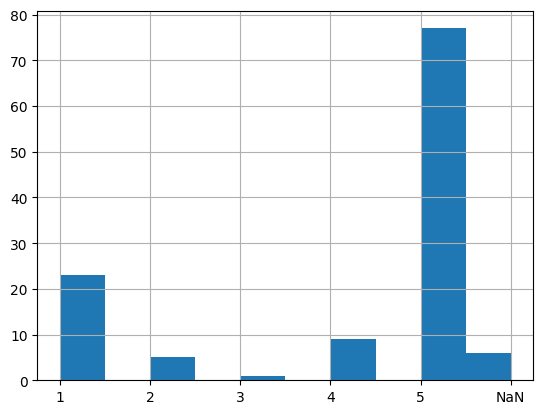

In [13]:
evaluated_ans_df.eval_score.sort_values().hist()

In [ ]:
if not os.path.exists("./output"):
    os.mkdir("./output")

for chunk_size in [200]:  # Add other chunk sizes (in tokens) as needed
    for embeddings in ["thenlper/gte-small"]:  # Add other embeddings as needed
        for rerank in [True, False]:
            settings_name = f"chunk:{chunk_size}_embeddings:{embeddings.replace('/', '~')}_rerank:{rerank}_reader-model:{READER_MODEL_NAME}"
            output_file_name = f"./output/rag_{settings_name}.json"

            print(f"Running evaluation for {settings_name}:")

            print("Loading knowledge base embeddings...")
            knowledge_index = load_embeddings(
                RAW_KNOWLEDGE_BASE,
                chunk_size=chunk_size,
                embedding_model_name=embeddings,
            )

            print("Running RAG...")
            reranker = (
                RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
                if rerank
                else None
            )
            run_rag_tests(
                eval_dataset=eval_dataset,
                llm=READER_LLM,
                knowledge_index=knowledge_index,
                output_file=output_file_name,
                reranker=reranker,
                verbose=False,
                test_settings=settings_name,
            )

            print("Running evaluation...")
            evaluate_answers(
                output_file_name,
                eval_chat_model,
                evaluator_name,
                evaluation_prompt_template,
            )

### Inspect results

In [ ]:
import glob

outputs = []
for file in glob.glob("./output/*.json"):
    output = pd.DataFrame(json.load(open(file, "r")))
    output["settings"] = file
    outputs.append(output)
result = pd.concat(outputs)

In [ ]:
result["eval_score_GPT4"] = result["eval_score_GPT4"].apply(
    lambda x: int(x) if isinstance(x, str) else 1
)
result["eval_score_GPT4"] = (result["eval_score_GPT4"] - 1) / 4

In [ ]:
average_scores = result.groupby("settings")["eval_score_GPT4"].mean()
average_scores.sort_values()

settings
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:False_reader-model:zephyr-7b-beta.json       0.884328
./output/rag_chunk:200_embeddings:BAAI~bge-base-en-v1.5_rerank:False_reader-model:zephyr-7b-beta.json    0.906716
./output/rag_chunk:200_embeddings:BAAI~bge-base-en-v1.5_rerank:True_reader-model:zephyr-7b-beta.json     0.906716
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:True_reader-model:mixtral.json               0.906716
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:True_reader-model:zephyr-7b-beta.json        0.921642
./output/rag_chunk:200_embeddings:thenlper~gte-small_rerank:True_reader-model:mixtral0.json              0.947761
Name: eval_score_GPT4, dtype: float64

## Example results

Let us load the results that I obtained by tweaking the different options available in this notebook.
For more detail on why these options could work on not, see the notebook on [advanced_RAG](advanced_rag).

As you can see in the graph below, some tweaks do not bring any improvement, some give huge performance boosts.

➡️ ___There is no single good recipe: you should try several different directions when tuning your RAG systems.___


In [ ]:
import plotly.express as px

scores = datasets.load_dataset("m-ric/rag_scores_cookbook", split="train")
scores = pd.Series(scores["score"], index=scores["settings"])

In [ ]:
fig = px.bar(
    scores,
    color=scores,
    labels={
        "value": "Accuracy",
        "settings": "Configuration",
    },
    color_continuous_scale="bluered",
)
fig.update_layout(w
    width=1000,
    height=600,
    barmode="group",
    yaxis_range=[0, 100],
    title="<b>Accuracy of different RAG configurations</b>",
    xaxis_title="RAG settings",
    font=dict(size=15),
)
fig.layout.yaxis.ticksuffix = "%"
fig.update_coloraxes(showscale=False)
fig.update_traces(texttemplate="%{y:.1f}", textposition="outside")
fig.show()